In [76]:
import os
import sys

sys.path.append('..')

import torch
import models_mae
from knn_test import KNN
from collections import OrderedDict

from pl_train import Encoder, LightningMAE, get_dino_model

from torch import nn
from tqdm import tqdm
from util.get_dataloader import get_dataloader

from torchmetrics import AUROC
import matplotlib.pyplot as plt

import numpy as np

In [86]:
conv = [128, 256, 512, 1024]
train_loss = {}
val_loss = {}
val_acc = {}
for i in conv:
    path = f'/mnt/lwll/lwll-coral/hrant/mae_checkpoints/cs_256_mae_bilin_conv_{i}/'
    with open(path + 'train_loss.log') as f:
        loss = f.readlines()
    train_loss[i] = [float(x.strip()) for x in loss]
    
    with open(path + 'val_loss.log') as f:
        loss = f.readlines()
    val_loss[i] = [float(x.strip()[7:-1]) for x in loss]
    
    with open(path + 'val_auc.log') as f:
        val_auc = f.readlines()
    val_auc = [float(x.strip()[7:-1]) for x in val_auc]

In [87]:
len(train_loss[128]), len(train_loss[256]), len(train_loss[512]), len(train_loss[1024])

(28883, 32943, 44195, 46400)

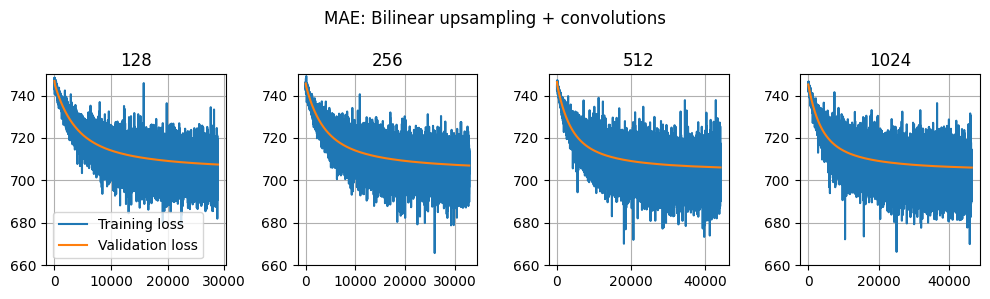

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
fig.suptitle('MAE: Bilinear upsampling + convolutions')
for i, key in enumerate(train_loss.keys()):
    x = range(len(train_loss[key]))
    x_val = np.linspace(0, len(train_loss[key]), len(val_loss[key]))
    axes[i].set_title(key)
    axes[i].plot(x, train_loss[key], label='Training loss')
    axes[i].plot(x_val, val_loss[key], label='Validation loss')
    axes[i].set_ylim([660, 750])
    axes[i].grid()
    
axes[0].legend()
fig.tight_layout()

In [84]:
# path = '/mnt/lwll/lwll-coral/hrant/mae_checkpoints/f1m_250_mae_bilinear_upsampling_8shot/'
conv = 128
model = 'dino'
# path = f'/mnt/lwll/lwll-coral/hrant/mae_checkpoints/cs_256_{model}_bilin_conv_{conv}/'
# path = f'/mnt/lwll/lwll-coral/hrant/mae_checkpoints/cs_256_{model}_bilinear_upsampling/'
path = f'/mnt/lwll/lwll-coral/hrant/mae_checkpoints/cs_256_{model}_deconvolution/'

with open(path + 'train_loss.log') as f:
    train_loss = f.readlines()
train_loss = [float(x.strip()) for x in train_loss]


with open(path + 'val_loss.log') as f:
    val_loss = f.readlines()
val_loss = [float(x.strip()[7:-1]) for x in val_loss]


with open(path + 'val_auc.log') as f:
    val_auc = f.readlines()
val_auc = [float(x.strip()[7:-1]) for x in val_auc]

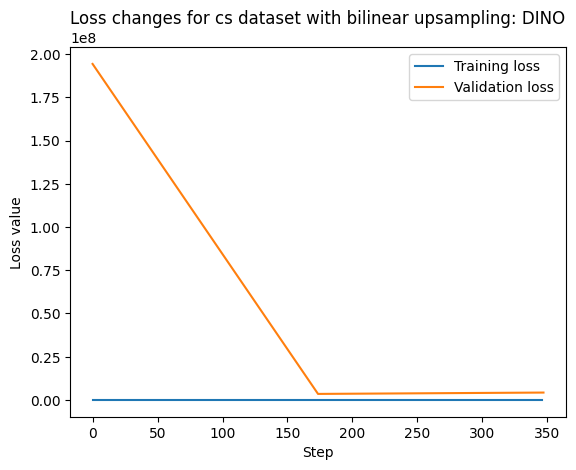

In [85]:
x = range(len(train_loss))
x_val = np.linspace(0, len(train_loss), len(val_loss))
plt.title('Loss changes for cs dataset with bilinear upsampling: DINO')
plt.xlabel('Step')
plt.ylabel('Loss value')
plt.plot(x, train_loss, label='Training loss')
plt.plot(x_val, val_loss, label='Validation loss')
plt.ylim
plt.legend();

13819789886.0


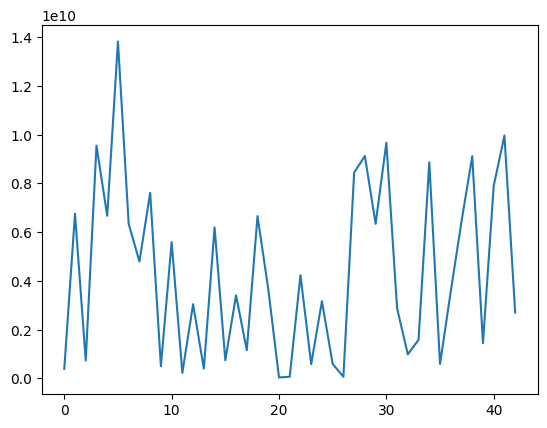

In [70]:
plt.plot(val_auc);
print(max(val_auc))

In [45]:
activation = nn.Softmax(dim=-1)

In [3]:
auc = AUROC(task="multiclass", num_classes=34)

In [3]:
annotation_train, annotation_val = '../annotations/cs4pc_256_train.npy', '../annotations/cs4pc_256_val.npy'
dataset_name = 'cs'


dataloader, dataloader_val, num_classes, dataset = get_dataloader(dataset_name=dataset_name, \
    train_annotation_file=annotation_train, val_annotation_file=annotation_val, \
    intersection_threshold=0.3, batch_size=20, \
    weighted=False, return_dataset=True)

In [9]:
def get_model(model_name, emb_size):
    device = 'cuda'
    arch='mae_vit_large_patch16'
    model_mae = getattr(models_mae, arch)()

    chkpt_dir = '../mae_visualize_vit_large_ganloss.pth'
    checkpoint = torch.load(chkpt_dir, map_location=device)
    msg = model_mae.load_state_dict(checkpoint['model'], strict=False)
    print(msg)

    encoder = Encoder(model=model_mae, num_classes=33, backbone_freeze=True, 
                      model_name=model_name, emb_size=emb_size, deconvolution=False,
                      bilinear_upsampling=True)
    return encoder.to('cuda')

In [10]:
model = get_model('mae', 1024)

<All keys matched successfully>


In [6]:
model()

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_init_weights',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_d

In [7]:
def f(x):
    try: return int(x[6:9])
    except ValueError: 
        try: return int(x[6:8])
        except ValueError: return int(x[6:7])


def load_checkpoints(model, weights):
    keys = [i for i in model.state_dict().keys()]

    od = OrderedDict()

    for key_chpt, key_model in zip(weights['state_dict'].keys(), keys):
        if key_model == key_chpt[10:]:
            od[key_model] = weights['state_dict'][key_chpt]
        else:
            print(key_model, key_chpt, dep='\t')

    model.load_state_dict(od, strict=False)
    return model

In [8]:
root = '/mnt/lwll/lwll-coral/hrant/mae_checkpoints/'
paths = [os.path.join(root, f'cs_256_mae_bilinear_upsampling_lr_1e{i}') for i in [2, 3, 4]]
res = []
for path in paths:
    tmp_dct = {}
    tmp = os.listdir(path)
    tmp.remove('last.ckpt')
    checkpoints = sorted(tmp, key=f)
    for ckpt in tqdm(checkpoints, total=len(checkpoints)):
        ckpt_path = os.path.join(path, ckpt)
        weights = torch.load(ckpt_path)
        model = load_checkpoints(model, weights)
        
        model.eval()
        predictions = []
        labels = []
        for ds in dataloader_val:
            img = torch.einsum('nhwc->nchw', ds['image']).to('cuda')
            img_enc = model(img.float())
            img = img.detach().to('cpu')
            img_enc = img_enc.detach().to('cpu')
            predictions.append(activation(img_enc))
            labels.append(ds['patch_56x56'])

        labels = torch.cat(labels, dim=0).reshape(-1)
        predictions = torch.cat(predictions, dim=0).reshape(-1, predictions[0].shape[-1])
        
        tmp_dct[f(ckpt)] = auc(predictions, labels)
    res.append(tmp_dct)

  0%|                                                              | 0/100 [00:00<?, ?it/s]/home/hkhachatrian/mae/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
100%|██████████████████████████████████████████████████| 100/100 [1:34:40<00:00, 56.81s/it]


In [11]:
import matplotlib.pyplot as plt

In [16]:
lre2 = [x.item() for x in res[0].values()]
lre3 = [x.item() for x in res[1].values()]
lre4 = [x.item() for x in res[2].values()]

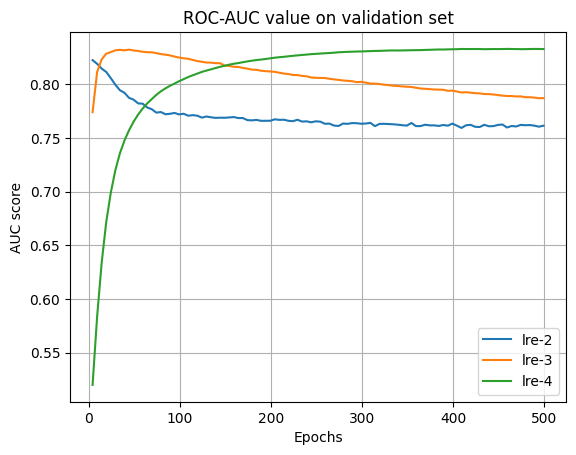

In [23]:
plt.plot(res[0].keys(), lre2, label='lre-2')
plt.plot(res[0].keys(), lre3, label='lre-3')
plt.plot(res[0].keys(), lre4, label='lre-4')
plt.title('ROC-AUC value on validation set')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('AUC score')
plt.legend();

In [10]:
len(res)

3

In [13]:
predictions[0].shape

torch.Size([20, 3136, 34])

In [51]:
labels.shape

torch.Size([3010560])